In [33]:
import datetime
import os
import random
import time
from argparse import Namespace
from pathlib import Path

import numpy as np
import sacred
import torch
import yaml
from torch.utils.data import DataLoader, DistributedSampler

import trackformer.util.misc as utils
from trackformer.datasets import build_dataset
from trackformer.engine import evaluate, train_one_epoch
from trackformer.models import build_model
from trackformer.util.misc import nested_dict_to_namespace
from trackformer.util.plot_utils import get_vis_win_names
from trackformer.vis import build_visualizers
import torchvision

In [34]:
import argparse
args = argparse.Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, lr_track=0.0001, overwrite_lrs=False, overwrite_lr_scheduler=False, batch_size=1, weight_decay=0.0001, epochs=80, lr_drop=50, clip_max_norm=0.1, deformable=True, with_box_refine=True, two_stage=False, freeze_detr=False, load_mask_head_from_model=None, backbone='resnet50', dilation=False, position_embedding='sine', num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=288, dropout=0.1, nheads=8, num_queries=500, pre_norm=False, dec_n_points=4, enc_n_points=4, tracking=True, tracking_eval=True, track_prev_frame_range=5, track_prev_frame_rnd_augs=0.01, track_prev_prev_frame=False, track_backprop_prev_frame=False, track_query_false_positive_prob=0.1, track_query_false_negative_prob=0.4, track_query_false_positive_eos_weight=True, track_attention=False, multi_frame_attention=True, multi_frame_encoding=True, multi_frame_attention_separate_encoder=True, merge_frame_features=False, overflow_boxes=True, masks=False, set_cost_class=2.0, set_cost_bbox=5.0, set_cost_giou=2.0, aux_loss=True, mask_loss_coef=1.0, dice_loss_coef=1.0, cls_loss_coef=2.0, bbox_loss_coef=5.0, giou_loss_coef=2, eos_coef=0.1, focal_loss=True, focal_alpha=0.25, focal_gamma=2, dataset='mot_crowdhuman', train_split=None, val_split='mot17_train_cross_val_frame_0_5_to_1_0_coco', coco_path='data/coco_2017', coco_panoptic_path=None, mot_path_train='data/MOT17', mot_path_val='data/MOT17', crowdhuman_path='data/CrowdHuman', crowdhuman_train_split='train_val', coco_person_train_split=None, coco_and_crowdhuman_prev_frame_rnd_augs=0.2, coco_min_num_objects=0, img_transform=argparse.Namespace(max_size=1333, val_width=800), output_dir='models/crowdhuman_deformable_multi_frame', device='cuda', seed=42, resume='', resume_shift_neuron=False, resume_optim=False, resume_vis=False, start_epoch=1, eval_only=False, eval_train=False, num_workers=2, val_interval=5, debug=False, save_model_interval=5, world_size=1, dist_url='env://', vis_server='', vis_port=8090, vis_and_log_interval=50, no_vis=False)

In [35]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [36]:
import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [37]:
device = "cuda"
seed = args.seed + utils.get_rank()

os.environ['PYTHONHASHSEED'] = str(seed)
# os.environ['NCCL_DEBUG'] = 'INFO'
# os.environ["NCCL_TREE_THRESHOLD"] = "0"

np.random.seed(seed)
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [38]:
model, criterion, postprocessors = build_model(args)
model.to(device)

/home/maksimgaiduk/miniconda3/envs/trackformer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maksimgaiduk/miniconda3/envs/trackformer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeformableDETRTracking(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=288, out_features=256, bias=True)
            (attention_weights): Linear(in_features=288, out_features=128, bias=True)
            (value_proj): Linear(in_features=288, out_features=288, bias=True)
            (output_proj): Linear(in_features=288, out_features=288, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=288, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=288, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((288,), eps=1e-05, ele

In [39]:
dataset_train = build_dataset(split='train', args=args)

loading annotations into memory...
Done (t=2.88s)
creating index...
index created!


In [40]:
example = dataset_train[0]
example

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

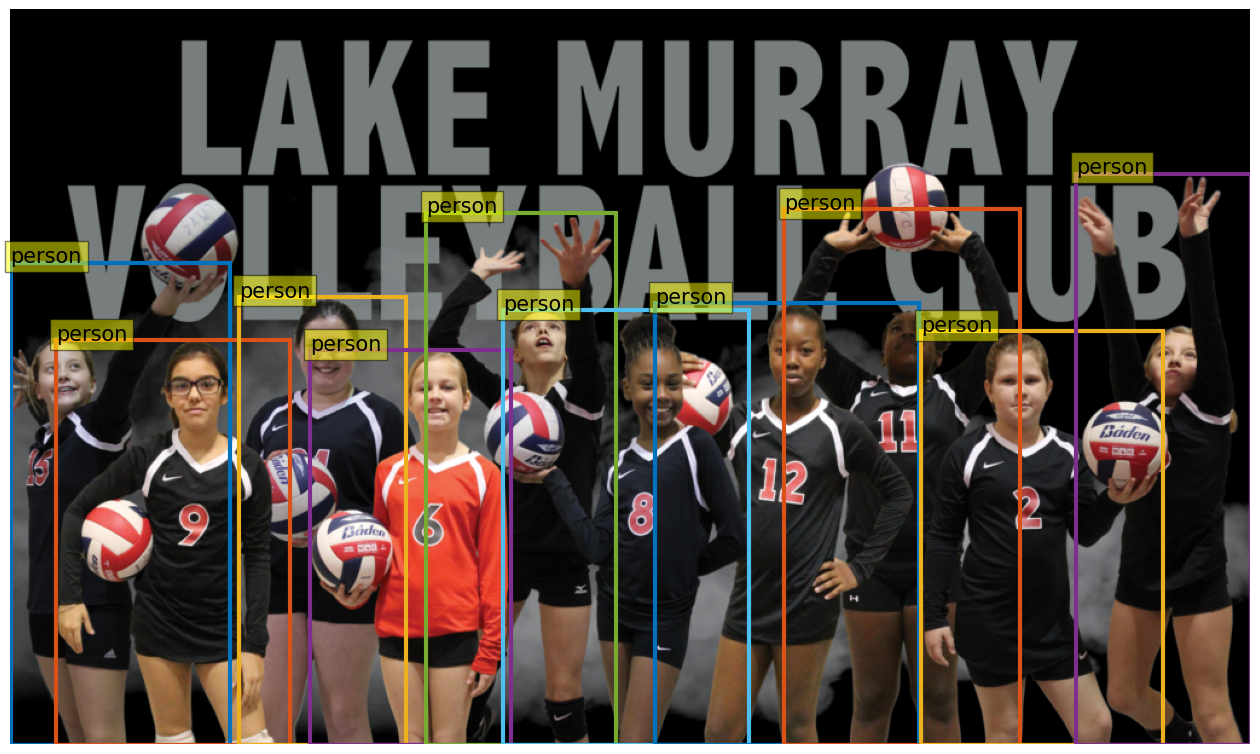

In [41]:
%matplotlib inline
plot_results(example[0], example[1]["labels"], example[1]["boxes"])

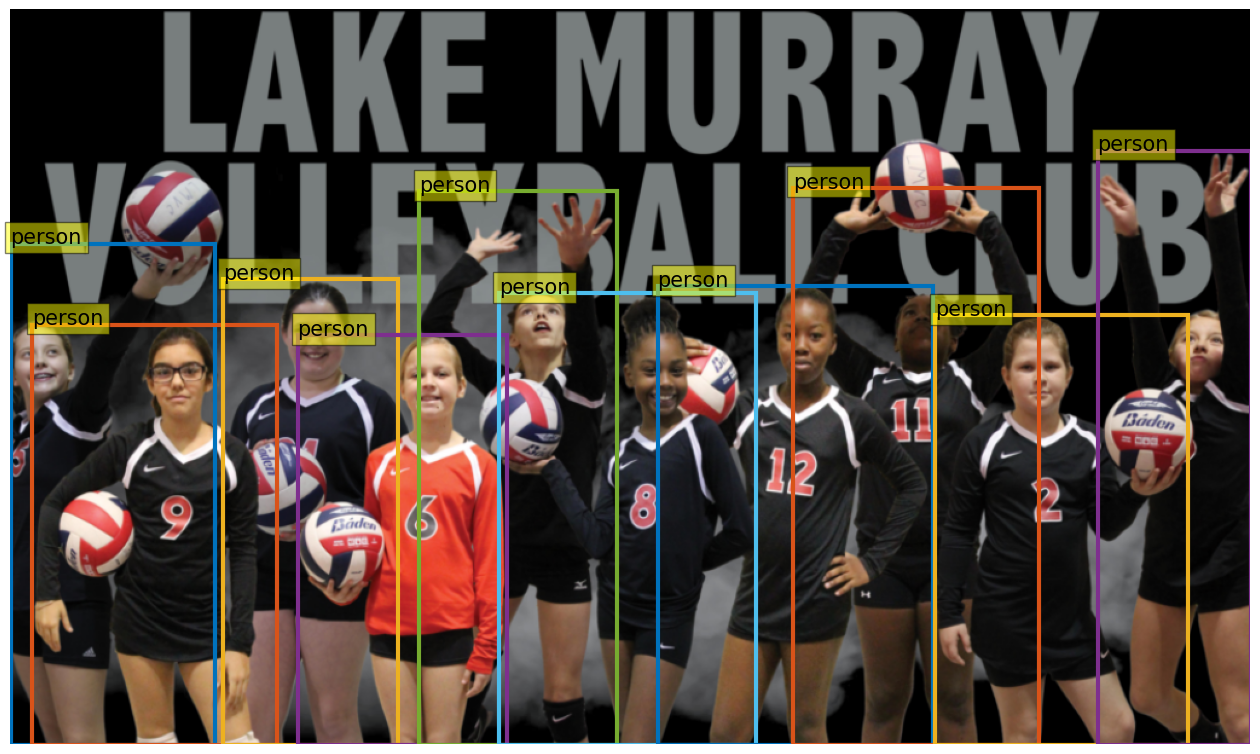

In [42]:
plot_results(example[1]["prev_image"], example[1]["prev_target"]["labels"], example[1]["prev_target"]["boxes"])

In [43]:
example[1]

{'boxes': tensor([[0.0886, 0.6721, 0.1772, 0.6559],
         [0.1308, 0.7248, 0.1888, 0.5504],
         [0.2516, 0.6953, 0.1352, 0.6093],
         [0.3222, 0.7316, 0.1620, 0.5368],
         [0.4117, 0.6380, 0.1530, 0.7240],
         [0.4962, 0.7045, 0.1987, 0.5910],
         [0.6259, 0.6998, 0.2130, 0.6003],
         [0.7189, 0.6357, 0.1897, 0.7287],
         [0.8316, 0.7188, 0.1952, 0.5625],
         [0.9296, 0.6115, 0.1407, 0.7770]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'image_id': tensor([0]),
 'area': tensor([ 90875.5156,  83858.1797,  64891.3828,  70577.9609,  82084.2969,
          93674.1953, 101617.9141, 101402.8906,  88703.1250,  79450.9062]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([3888, 6567]),
 'size': tensor([ 608, 1026]),
 'track_ids': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'labels_ignore': tensor([], dtype=torch.int64),
 'area_ignore': tensor([]),
 'iscrowd_ignore': tensor([], dtype=torch.int64),
 'boxes_ignore': tensor(

In [44]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(
        dataset_train,
        batch_sampler=batch_sampler_train,
        collate_fn=utils.collate_fn,
        num_workers=args.num_workers)

In [45]:
for samples, targets in data_loader_train:
    break
targets, samples

(({'boxes': tensor([[0.9229, 0.6212, 0.1542, 0.7575],
           [0.7853, 0.5646, 0.2232, 0.8212],
           [0.6742, 0.6478, 0.2472, 0.7044],
           [0.4364, 0.6442, 0.2202, 0.7115],
           [0.2983, 0.6239, 0.1542, 0.7522],
           [0.1562, 0.4982, 0.1982, 0.8867],
           [0.4895, 0.5646, 0.1281, 0.6726],
           [0.6146, 0.5584, 0.1782, 0.8832],
           [0.4214, 0.3841, 0.0961, 0.4779],
           [0.3684, 0.2690, 0.0841, 0.4142],
           [0.4750, 0.2425, 0.0791, 0.4035],
           [0.2192, 0.4177, 0.1421, 0.7292]]),
   'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   'image_id': tensor([8265]),
   'area': tensor([ 66510.9688,  95836.5547, 148473.8594,  82525.0938,  61190.8320,
            91877.9453,  45050.7383,  88532.4766,  24007.3008,  18205.5371,
            16682.8516,  54186.8477]),
   'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   'orig_size': tensor([565, 999]),
   'size': tensor([544, 961]),
   'track_ids': tensor([ 0,  1,  

In [46]:
%pip install ipykernel

881.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [47]:
samples = samples.to(device)
targets = [utils.nested_dict_to_device(t, device) for t in targets]
preds = model(samples, targets)
preds

/home/maksimgaiduk/miniconda3/envs/trackformer/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


({'pred_logits': tensor([[[-4.7738, -3.7259, -4.8964,  ..., -4.9803, -4.3187, -3.9045],
           [-4.1558, -3.7305, -5.1395,  ..., -4.5802, -4.2117, -3.4705],
           [-4.4660, -3.8441, -5.1209,  ..., -4.8692, -4.4052, -4.3066],
           ...,
           [-4.4055, -3.3790, -5.0738,  ..., -4.5709, -4.2276, -3.8064],
           [-4.2006, -3.6841, -5.6277,  ..., -5.0452, -5.0884, -4.1184],
           [-4.0189, -3.8549, -5.0381,  ..., -4.6890, -4.1153, -3.6331]]],
         device='cuda:0', grad_fn=<SelectBackward0>),
  'pred_boxes': tensor([[[0.6284, 0.4893, 0.1192, 0.1192],
           [0.3403, 0.8106, 0.1192, 0.1192],
           [0.7280, 0.9756, 0.1192, 0.1192],
           ...,
           [0.7452, 0.5115, 0.1192, 0.1192],
           [0.8584, 0.7918, 0.1192, 0.1192],
           [0.4632, 0.4980, 0.1192, 0.1192]]], device='cuda:0',
         grad_fn=<SelectBackward0>),
  'hs_embed': tensor([[[-2.0584,  0.1742, -0.7013,  ...,  0.3942, -0.2044,  1.1386],
           [-2.1438, -0.0281, -0.5

In [50]:
preds[0]["pred_logits"].shape

torch.Size([1, 500, 20])

In [7]:
args2 = Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, lr_track=0.0001, overwrite_lrs=False, overwrite_lr_scheduler=False, batch_size=1, weight_decay=0.0001, epochs=50, lr_drop=10, clip_max_norm=0.1, deformable=True, with_box_refine=True, two_stage=False, freeze_detr=False, load_mask_head_from_model=None, backbone='resnet50', dilation=False, position_embedding='sine', num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=288, dropout=0.1, nheads=8, num_queries=500, pre_norm=False, dec_n_points=4, enc_n_points=4, tracking=True, tracking_eval=True, track_prev_frame_range=5, track_prev_frame_rnd_augs=0.01, track_prev_prev_frame=False, track_backprop_prev_frame=False, track_query_false_positive_prob=0.1, track_query_false_negative_prob=0.4, track_query_false_positive_eos_weight=True, track_attention=False, multi_frame_attention=True, multi_frame_encoding=True, multi_frame_attention_separate_encoder=True, merge_frame_features=False, overflow_boxes=True, masks=False, set_cost_class=2.0, set_cost_bbox=5.0, set_cost_giou=2.0, aux_loss=True, mask_loss_coef=1.0, dice_loss_coef=1.0, cls_loss_coef=2.0, bbox_loss_coef=5.0, giou_loss_coef=2, eos_coef=0.1, focal_loss=True, focal_alpha=0.25, focal_gamma=2, dataset='mot', train_split='mot17_train_coco', val_split='mot17_train_cross_val_frame_0_5_to_1_0_coco', coco_path='data/coco_2017', coco_panoptic_path=None, mot_path_train='data/MOT17', mot_path_val='data/MOT17', crowdhuman_path='data/CrowdHuman', crowdhuman_train_split=None, coco_person_train_split=None, coco_and_crowdhuman_prev_frame_rnd_augs=0.2, coco_min_num_objects=0, img_transform=Namespace(max_size=1333, val_width=800), output_dir='models/mot17_crowdhuman_deformable_multi_frame', device='cuda', seed=42, resume='models/r50_deformable_detr_plus_iterative_bbox_refinement-checkpoint_hidden_dim_288.pth', resume_shift_neuron=False, resume_optim=False, resume_vis=False, start_epoch=1, eval_only=False, eval_train=False, num_workers=2, val_interval=5, debug=False, save_model_interval=5, world_size=1, dist_url='env://', vis_server='', vis_port=8090, vis_and_log_interval=50, no_vis=False)

In [13]:
args.dataset

'mot_crowdhuman'

In [8]:
dataset_train2 = build_dataset(split='train', args=args2)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


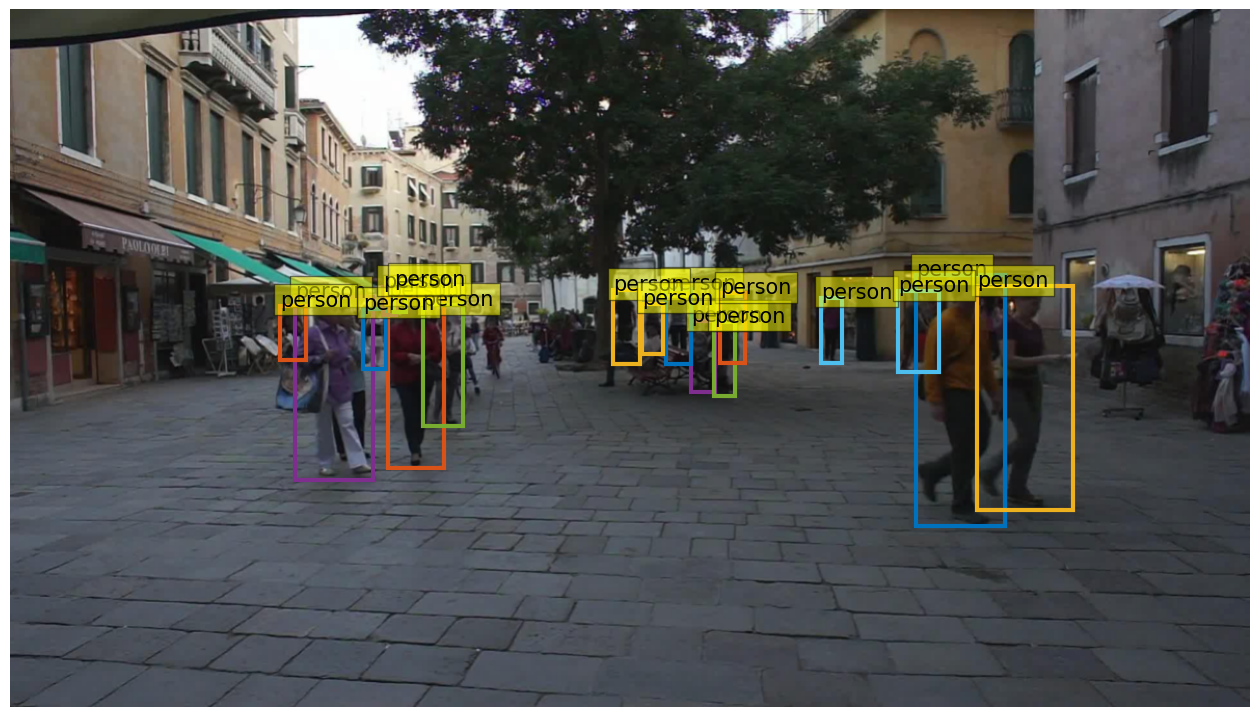

In [31]:
#i = 0
example2 = dataset_train2[i]
i += 1
plot_results(example2[1]["prev_image"], example2[1]["prev_target"]["labels"], example2[1]["prev_target"]["boxes"])

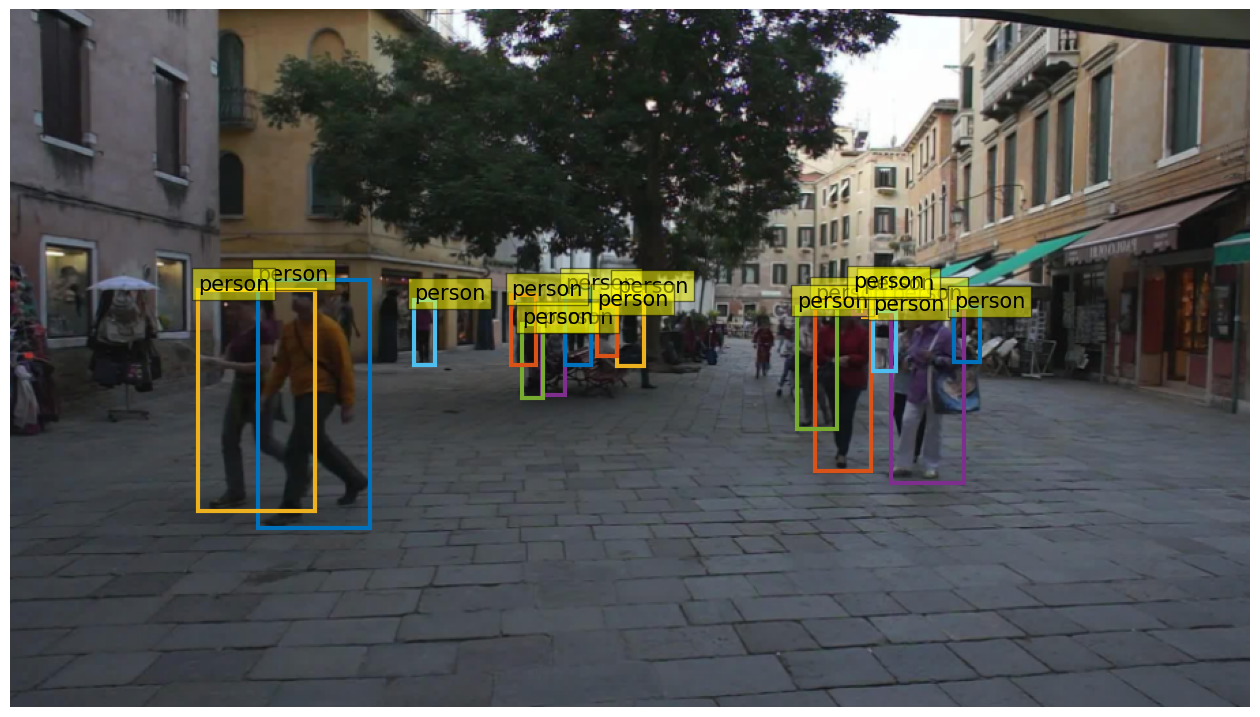

In [17]:
%matplotlib inline
plot_results(example2[1]["prev_image"], example2[1]["prev_target"]["labels"], example2[1]["prev_target"]["boxes"])

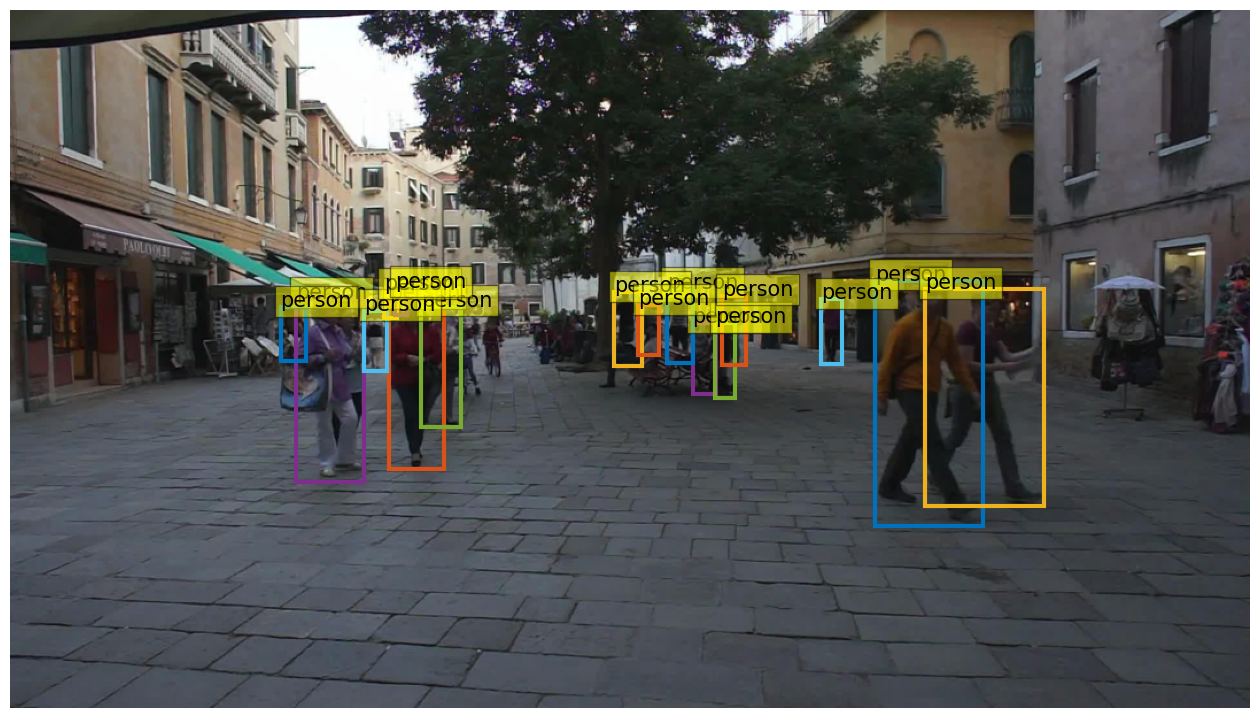

In [12]:
plot_results(example2[0], example2[1]["labels"], example2[1]["boxes"])